In [37]:
!pip install imageio matplotlib numpy imageio_ffmpeg

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.12/site-packages/starrynet-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 42.4 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


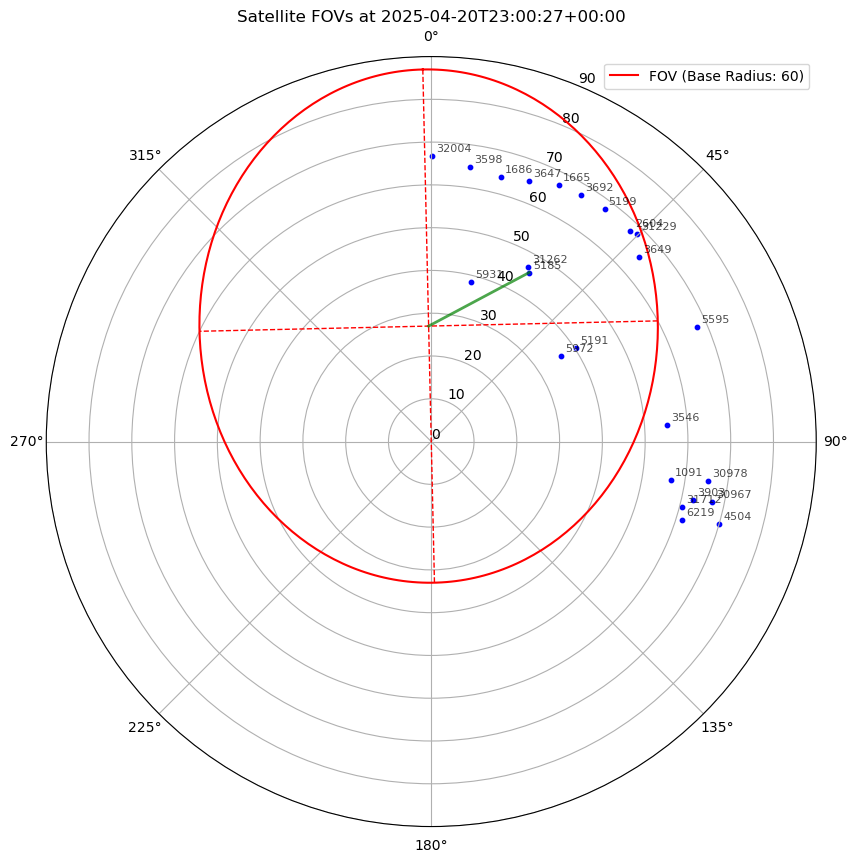

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math

def rotate_points(x, y, angle):
    """Rotates points by the given angle."""
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(ax, tilt_deg, rotation_deg, base_radius, satellites, connected_satellite):
    """Draws the FOV ellipse with given tilt, rotation, and base radius, and adds satellite points."""
    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    # FOV ellipse and axes
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r', label=f'FOV (Base Radius: {base_radius})')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    # Calculate the center point of the FOV (intersection of major and minor axes)
    fov_center_x = center_shift
    fov_center_y = 0
    fov_center_x_rot, fov_center_y_rot = rotate_points(fov_center_x, fov_center_y, np.deg2rad(rotation_deg))
    fov_center_r = np.sqrt(fov_center_x_rot**2 + fov_center_y_rot**2)
    fov_center_theta = np.arctan2(fov_center_y_rot, fov_center_x_rot)

    # Scatter satellite positions with labels
    for sat in satellites:
        elevation = sat['altitude_deg']
        azimuth = sat['azimuth_deg']
        scatter_r = 90 - elevation  # Polar plot r (90 - Elevation degrees)
        scatter_theta = np.radians(azimuth)  # Polar plot theta (Azimuth in radians)
        ax.scatter(scatter_theta, scatter_r, color='blue', s=10)
        
        # Add label for each satellite
        satellite_name = sat['satellite'].split('-')[-1]  # Extract the number part of the satellite name
        ax.annotate(satellite_name, (scatter_theta, scatter_r), xytext=(3, 3), 
                    textcoords='offset points', fontsize=8, alpha=0.7)
        
        # Draw green line to connected satellite
        if satellite_name == connected_satellite:
            # Satellite polar position
            satellite_r = 90 - elevation  # Correct radius for satellite position
            satellite_theta = np.radians(azimuth)  # Correct angle for satellite position
            
            # Line from the center of the FOV to the satellite position
            ax.plot([fov_center_theta, satellite_theta], [fov_center_r, satellite_r], color='green', linewidth=2, alpha=0.7)

    ax.legend(loc='upper right')

# Load JSON data
with open("satellite_visibility.json", "r") as f:
    data = json.load(f)


# Select a timestamp (you can loop over them too)
timestamp = list(data.keys())[0]
satellites = data[timestamp]
tilt = data[timestamp][0]['tilt_deg']
rotation = data[timestamp][0]['rotation_deg']
# Create plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Draw FOV with connected satellite
connected_satellite = "5185"  # For example, using first satellite
draw_fov(ax, tilt_deg=tilt, rotation_deg=rotation, base_radius=60, satellites=satellites, connected_satellite=connected_satellite)

ax.set_title(f"Satellite FOVs at {timestamp}")
plt.show()


In [74]:
import imageio
import os
import matplotlib.pyplot as plt

def generate_video_from_satellites(data, output_video="satellite_fov.mp4", tilt_deg=27, rotation_deg=-1.3, base_radius=60, fps=2):
    # Temporary directory to save images
    os.makedirs("frames", exist_ok=True)
    frame_files = []
    connected_satellite = ["5185", "5507", "5507", "3629", "3072", "32697", "4208"]
    for i, (timestamp, satellites) in enumerate(data.items()):
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
        draw_fov(ax, tilt_deg=tilt_deg, rotation_deg=rotation_deg, base_radius=base_radius, satellites=satellites, connected_satellite=connected_satellite[i])
        ax.set_title(f"Satellite FOVs at {timestamp}")
        
        # Save frame
        filename = f"frames/frame_{i:03d}.png"
        plt.savefig(filename)
        frame_files.append(filename)
        plt.close(fig)

    # Create video
    with imageio.get_writer(output_video, mode='I', fps=fps) as writer:
        for filename in frame_files:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Clean up frame files
    for f in frame_files:
        os.remove(f)
    os.rmdir("frames")

    return output_video

In [75]:
generate_video_from_satellites(data, output_video="satellite_fov.mp4", fps=2)

/tmp/ipykernel_23637/3551069206.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
[rawvideo @ 0x40289400] Stream #0: not enough frames to estimate rate; consider increasing probesize


'satellite_fov.mp4'